#### Imports + tooling

In [7]:
import pandas as pd
import seaborn as sns
import scipy as sp
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import rcParams, colors

# figure size in inches
rcParams['figure.figsize'] = 12,8
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [8]:
def load_data(path):
    metadata = []
    with open(path) as f:
        header = 0
        while True:
            line = next(f)
            if line.startswith("#"):
                metadata.append(line)
                header += 1
            else:
                break
                
    column_name_map = {k: v for k, v in re.findall("COLUMN\s+(\w+):\s+([^,]+)", "".join(metadata))}
    df = pd.read_csv(path, skiprows=header, low_memory=False)
    df = df.rename(columns=column_name_map)

    return df

#### Load data

In [9]:
df = load_data("./data/NASA/planetary_systems_composite.csv")
len(df.index)

5241

In [10]:
list(df.columns)

['rowid',
 'Planet Name',
 'Host Name',
 'Planet Letter',
 'HD ID',
 'HIP ID',
 'TIC ID',
 'GAIA ID',
 'Number of Stars',
 'Number of Planets',
 'Number of Moons',
 'Circumbinary Flag',
 'Discovery Method',
 'Discovery Year',
 'Discovery Reference',
 'Discovery Publication Date',
 'Discovery Locale',
 'Discovery Facility',
 'Discovery Telescope',
 'Discovery Instrument',
 'Detected by Radial Velocity Variations',
 'Detected by Pulsar Timing Variations',
 'Detected by Pulsation Timing Variations',
 'Detected by Transits',
 'Detected by Astrometric Variations',
 'Detected by Orbital Brightness Modulations',
 'Detected by Microlensing',
 'Detected by Eclipse Timing Variations',
 'Detected by Imaging',
 'Detected by Disk Kinematics',
 'Controversial Flag',
 'Orbital Period [days]',
 'Orbital Period Upper Unc. [days]',
 'Orbital Period Lower Unc. [days]',
 'Orbital Period Limit Flag',
 'Orbital Period Reference',
 'Orbit Semi-Major Axis [au]',
 'Orbit Semi-Major Axis Upper Unc. [au]',
 'Orb

In [11]:
# 'Orbit Semi-Major Axis [au]'
# 'Planet Radius [Earth Radius]'
# 'Planet Mass or Mass*sin(i) [Earth Mass]'
# 'Planet Density [g/cm**3]'
# 'Eccentricity'
# 'Stellar Radius [Solar Radius]'
# 'Stellar Mass [Solar mass]'
# 'Stellar Metallicity [dex]'
# 'Stellar Age [Gyr]'
# 'Stellar Density [g/cm**3]'
# 'Stellar Rotational Period [days]'
# 'Data show Transit Timing Variations'

#### Analysis (ignoring eccentricity)

In [86]:
earth_radius = 6.378e6  # m
earth_mass = 5.972e24  # kg
solar_radius = 6.957e8 # m
solar_mass = 1.989e30  # kg

a = df['Orbit Semi-Major Axis [au]'] * sp.constants.au
Rs = df['Stellar Radius [Solar Radius]'] * solar_radius
Rp = df['Planet Radius [Earth Radius]'] * earth_radius
Mp = df['Planet Mass or Mass*sin(i) [Earth Mass]'] * earth_mass
Ms = df['Stellar Mass [Solar mass]'] * solar_mass

a_l = ((df['Orbit Semi-Major Axis [au]'] + df['Orbit Semi-Major Axis Lower Unc. [au]']) * sp.constants.au).fillna(a)
Rs_l = ((df['Stellar Radius [Solar Radius]'] + df['Stellar Radius Lower Unc. [Solar Radius]']) * solar_radius).fillna(Rs)
Rp_l = ((df['Planet Radius [Earth Radius]'] + df['Planet Radius Lower Unc. [Earth Radius]']) * earth_radius).fillna(Rs)
Mp_l = ((df['Planet Mass or Mass*sin(i) [Earth Mass]'] + df['Planet Mass or Mass*sin(i) [Earth Mass] Lower Unc.']) * earth_mass).fillna(Mp)
Ms_l = ((df['Stellar Mass [Solar mass]'] + df['Stellar Mass Lower Unc. [Solar mass]']) * solar_mass).fillna(Ms)

a_u = ((df['Orbit Semi-Major Axis [au]'] + df['Orbit Semi-Major Axis Upper Unc. [au]']) * sp.constants.au).fillna(a)
Rs_u = ((df['Stellar Radius [Solar Radius]'] + df['Stellar Radius Upper Unc. [Solar Radius]']) * solar_radius).fillna(Rs)
Rp_u = ((df['Planet Radius [Earth Radius]'] + df['Planet Radius Upper Unc. [Earth Radius]']) * earth_radius).fillna(Rs)
Mp_u = ((df['Planet Mass or Mass*sin(i) [Earth Mass]'] + df['Planet Mass or Mass*sin(i) [Earth Mass] Upper Unc.']) * earth_mass).fillna(Mp)
Ms_u = ((df['Stellar Mass [Solar mass]'] + df['Stellar Mass Upper Unc. [Solar mass]']) * solar_mass).fillna(Ms)

Qs = 10 ** 5.5

neg_da_dt = 9/2 * ((sp.constants.G / Ms) ** 0.5) * ((Rs ** 5 * Mp) / Qs) * (a ** -5.5)
neg_da_dt_lower_bound = 9/2 * ((sp.constants.G / Ms_u) ** 0.5) * ((Rs_l ** 5 * Mp_l) / Qs) * (a_u ** -5.5)
neg_da_dt_upper_bound = 9/2 * ((sp.constants.G / Ms_l) ** 0.5) * ((Rs_u ** 5 * Mp_u) / Qs) * (a_l ** -5.5)
lower_bound_error = neg_da_dt - neg_da_dt_lower_bound
upper_bound_error = neg_da_dt_upper_bound - neg_da_dt
neg_da_dt = neg_da_dt.rename("-da/dt [m/s]")


print(f"Out of {len(neg_da_dt.index)} planets we have data to compute an estimated decay for {neg_da_dt.notna().sum()}")

Out of 5241 planets we have data to compute an estimated decay for 4760


Text(0.5, 0, 'Predicted -da/dt [m/s]')

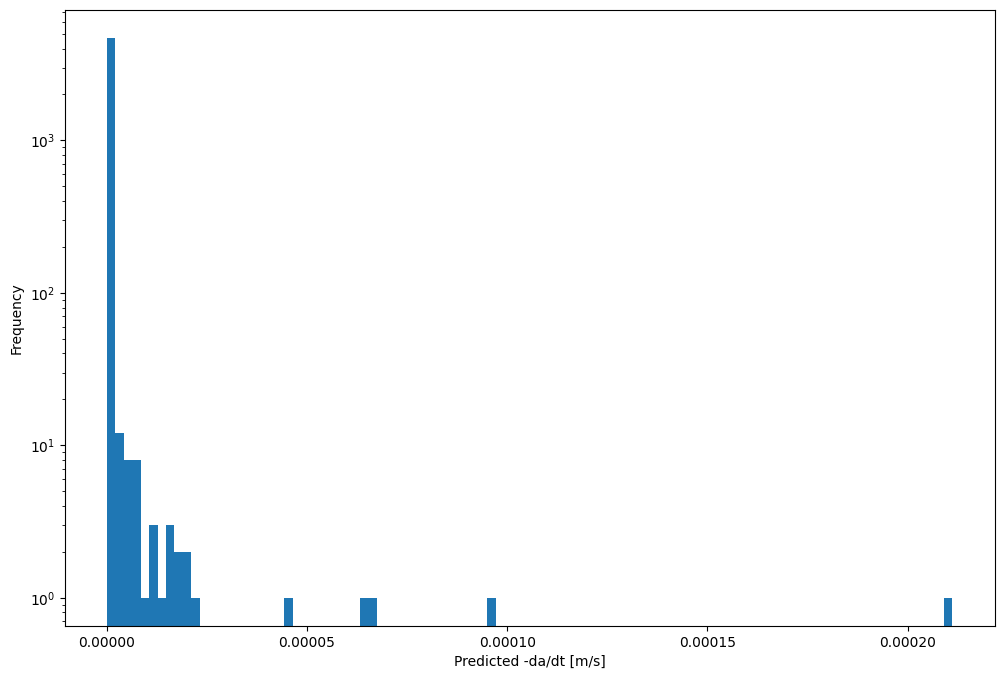

In [13]:
ax = neg_da_dt.plot.hist(bins=100, log=True)
ax.set_xlabel("Predicted -da/dt [m/s]")

What are the most extreme orbital decays we predict? How uncertain is this prediction?
Ranking da/dt by planet ID:

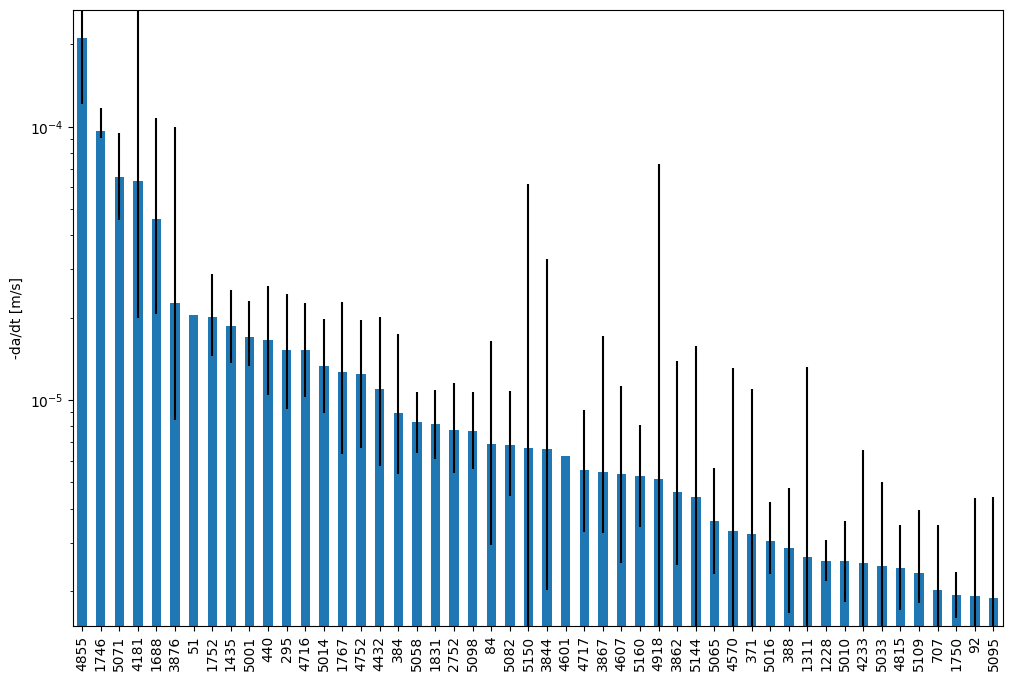

In [14]:
top_50_planets = neg_da_dt.sort_values(ascending=False).head(50)
top_50_errs = np.array(list(zip(lower_bound_error.loc[top_50_planets.index], upper_bound_error.loc[top_50_planets.index]))).transpose()
top_50_planets.plot.bar(ylabel=top_50_planets.name, yerr=top_50_errs, log=True)
plt.show()

How does orbital decay vary with orbital radius, planetary and stellar mass. Plot da/dt against orbital radius, planetary mass and stellar mass:

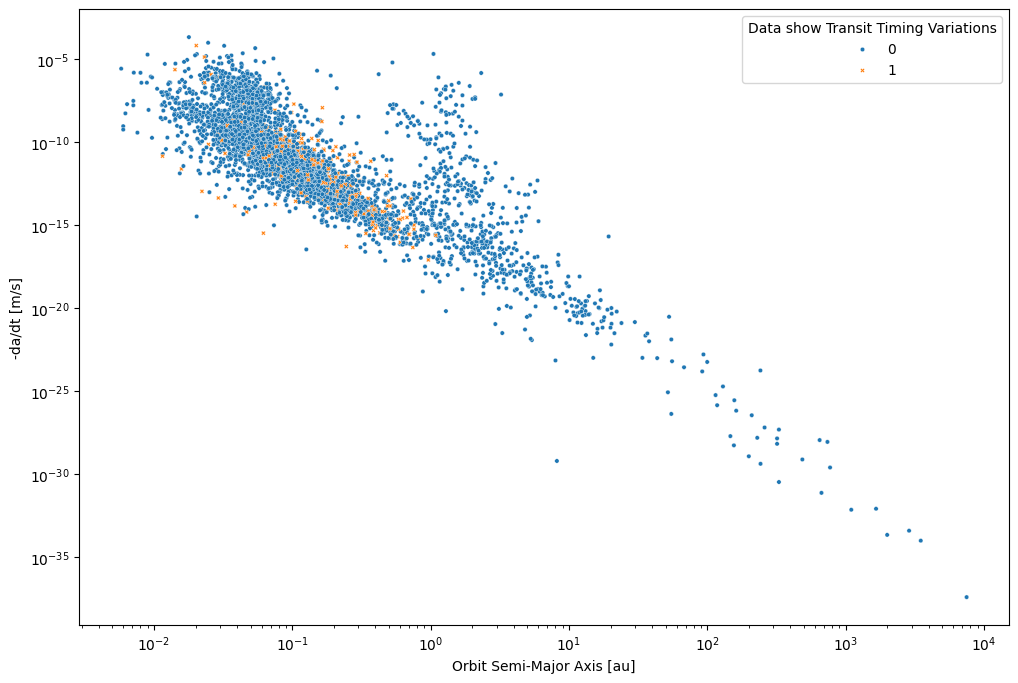

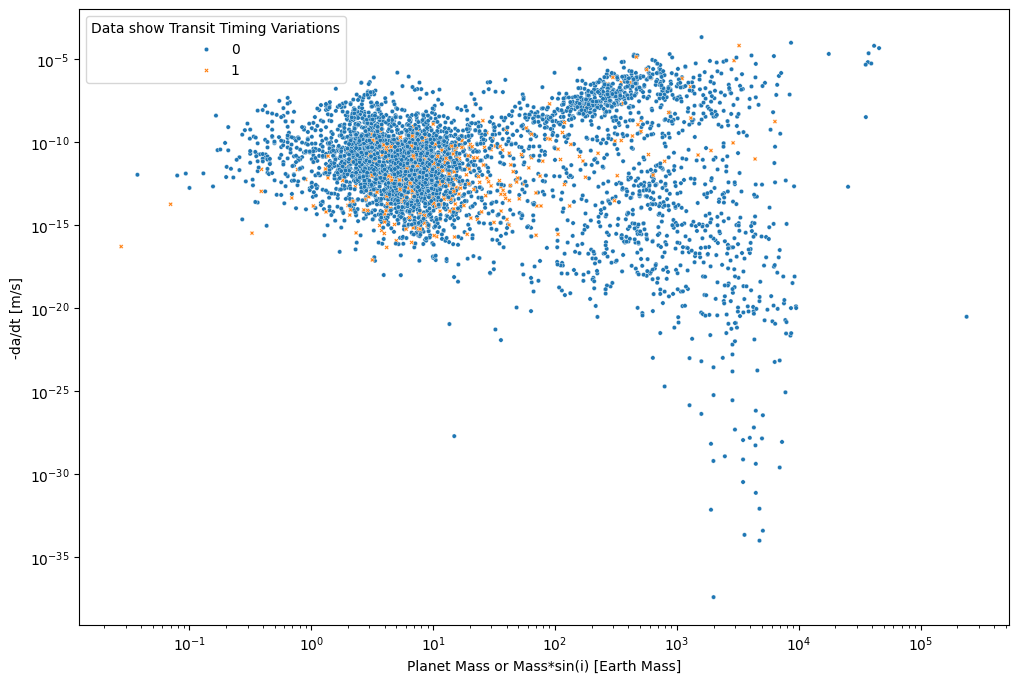

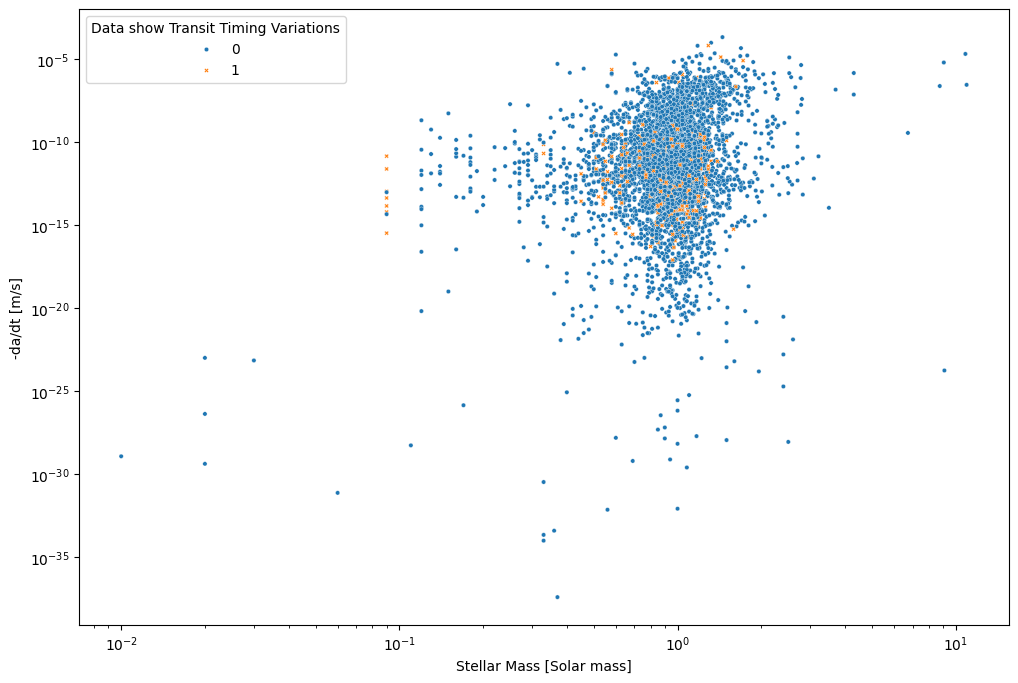

In [15]:
ax = sns.scatterplot(data=df,
                x=df['Orbit Semi-Major Axis [au]'],
                y=neg_da_dt,
                hue='Data show Transit Timing Variations',
                style='Data show Transit Timing Variations',
                s=10,
               )
ax.set(xscale="log", yscale="log")
plt.show()

ax = sns.scatterplot(data=df,
                x=df['Planet Mass or Mass*sin(i) [Earth Mass]'],
                y=neg_da_dt,
                hue='Data show Transit Timing Variations',
                style='Data show Transit Timing Variations',
                s=10,
               )
ax.set(xscale="log", yscale="log")
plt.show() 

ax = sns.scatterplot(data=df,
                x=df['Stellar Mass [Solar mass]'],
                y=neg_da_dt,
                hue='Data show Transit Timing Variations',
                style='Data show Transit Timing Variations',
                s=10,
               )
ax.set(xscale="log", yscale="log")
plt.show()

Under this model closer planets decay faster due to the 1/a^5.5 term. More massive planets decay a little faster too, as they have a greater tidal influence on their host star.

Double checking the relationship between radius of a planet and its mass:

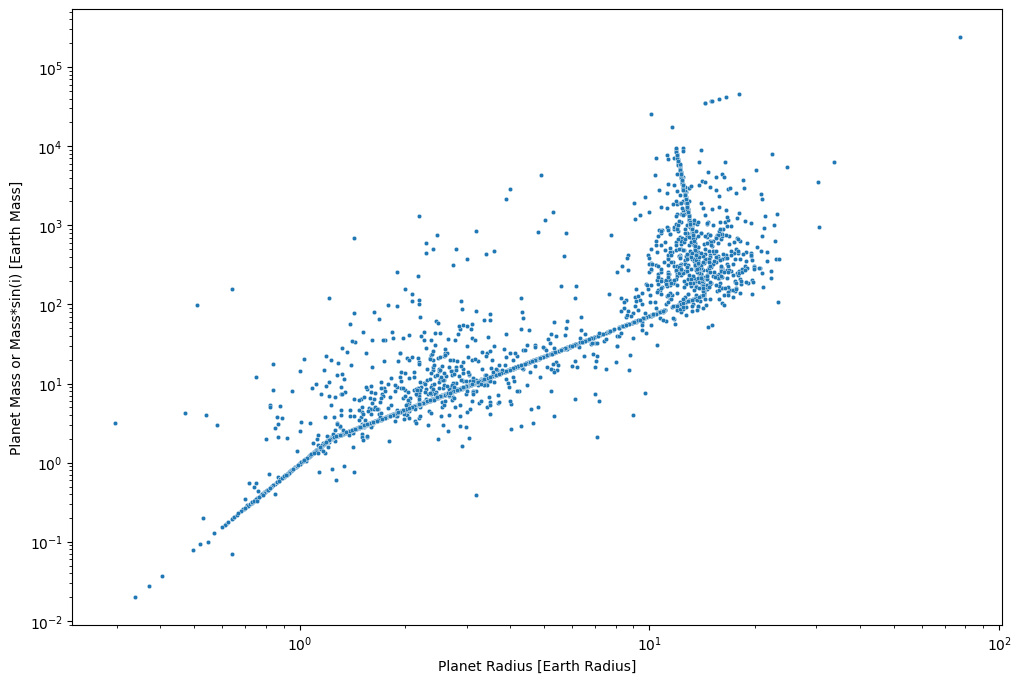

In [16]:
ax = sns.scatterplot(data=df,
                x=df['Planet Radius [Earth Radius]'],
                y=df['Planet Mass or Mass*sin(i) [Earth Mass]'],
                s=10,
               )
ax.set(xscale="log", yscale="log")
plt.show()

Do hot Jupiters decay more than other planets? Mass of planet vs semi-axis orbital radius:

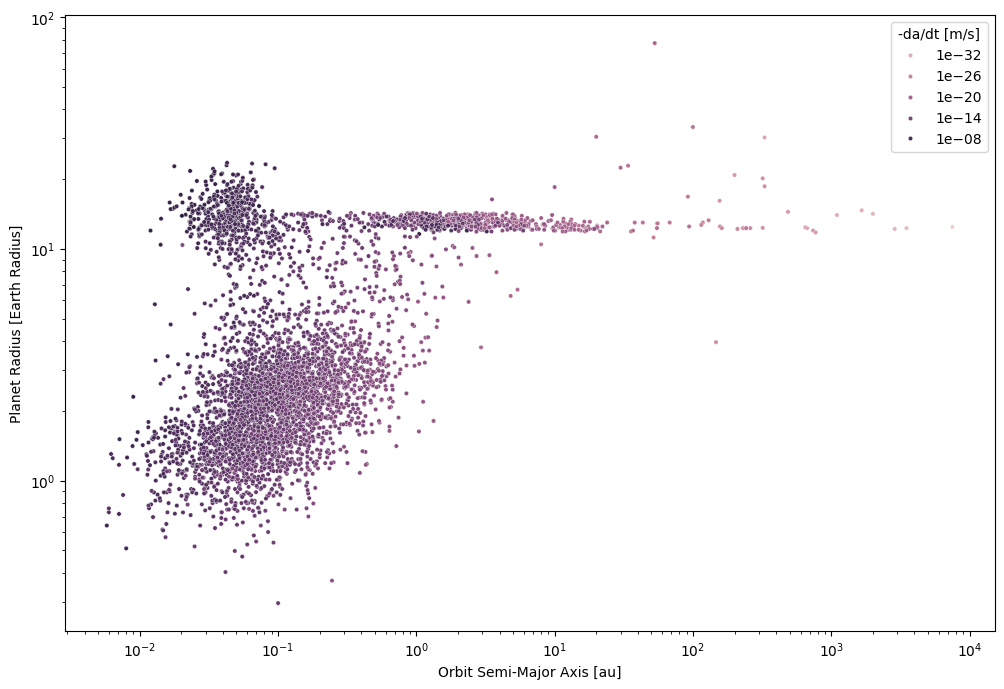

In [17]:
ax = sns.scatterplot(data=df,
                x=df['Orbit Semi-Major Axis [au]'],
                y=df['Planet Radius [Earth Radius]'],
                s=10,
                hue=neg_da_dt,
                hue_norm=colors.LogNorm(),
               )
ax.set(xscale="log", yscale="log")
plt.show()

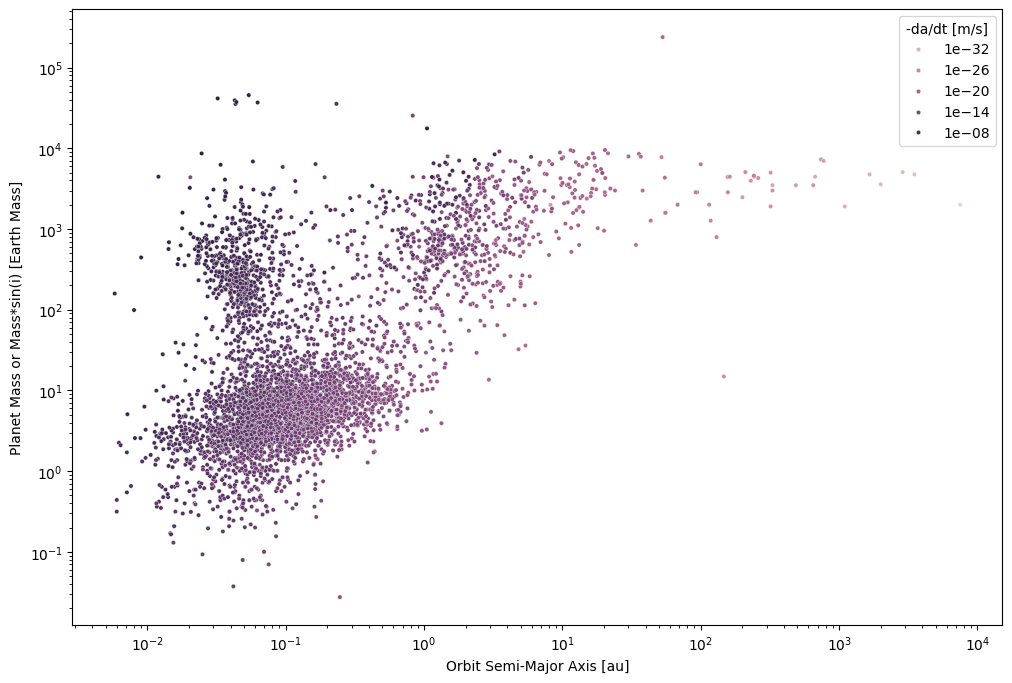

In [18]:
ax = sns.scatterplot(data=df,
                x=df['Orbit Semi-Major Axis [au]'],
                y=df['Planet Mass or Mass*sin(i) [Earth Mass]'],
                s=10,
                hue=neg_da_dt,
                hue_norm=colors.LogNorm(),
               )
ax.set(xscale="log", yscale="log")
plt.show()

Does the mass of the host star have much effect? Stellar mass vs semi-axis orbital radius:

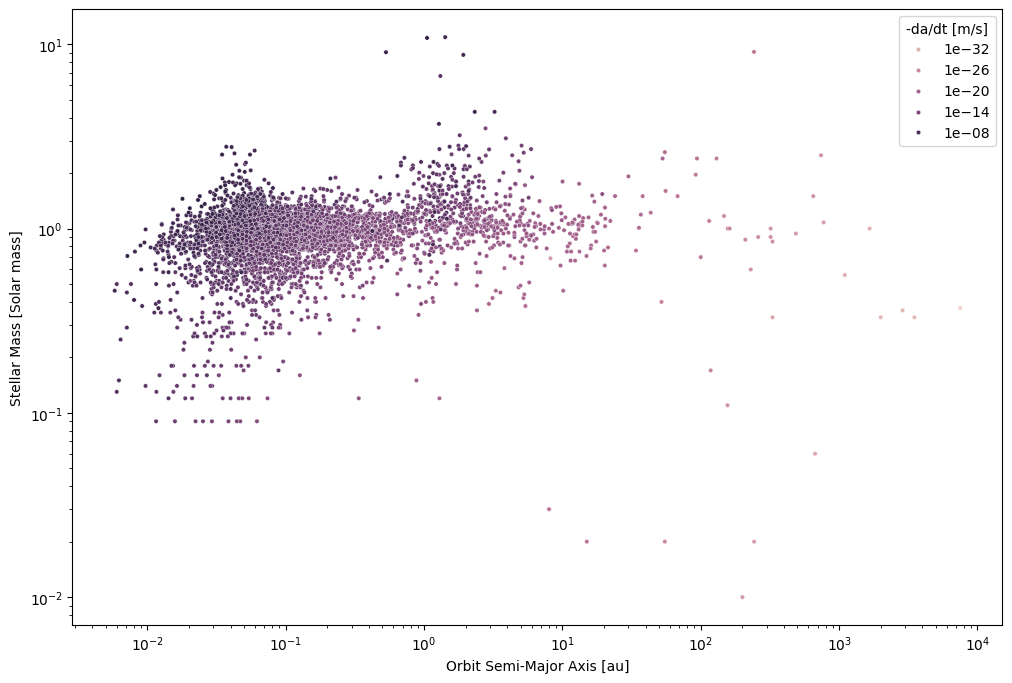

In [19]:
ax = sns.scatterplot(data=df,
                x=df['Orbit Semi-Major Axis [au]'],
                y=df['Stellar Mass [Solar mass]'],
                s=10,
                hue=neg_da_dt,
                hue_norm=colors.LogNorm(),
               )
ax.set(xscale="log", yscale="log")
plt.show()

Our simple equation suggests smaller stars will cause faster orbital decay, but when accounting for eccentricities we get a Ms^3/2 term which may dominate.

Looking at the top 20 planets:

In [20]:
fields = ['Planet Name', 'Orbit Semi-Major Axis [au]', 'Planet Radius [Earth Radius]', 'Planet Mass or Mass*sin(i) [Earth Mass]', 'Stellar Mass [Solar mass]', 'Stellar Radius [Solar Radius]', 'Data show Transit Timing Variations', 'Eccentricity']
df.loc[top_50_planets.index][fields].join(neg_da_dt).join(lower_bound_error.rename("-ve err")).join(upper_bound_error.rename("+ve err"))

Planet Name  Orbit Semi-Major Axis [au]  \
4855           TOI-2109 b                     0.01791   
1746             KELT-1 b                     0.02466   
5071            WASP-18 b                     0.02024   
4181         Kepler-718 b                     0.03220   
1688              K2-52 b                     0.05400   
3876         Kepler-493 b                     0.04390   
51           BD+20 2457 b                     1.05000   
1752            KELT-16 b                     0.02044   
1435              K2-22 b                     0.00900   
5001           WASP-103 b                     0.01985   
440             HATS-70 b                     0.03632   
295               GPX-1 b                     0.03380   
4716         OGLE-TR-56 b                     0.02383   
5014            WASP-12 b                     0.02320   
1767             KELT-9 b                     0.03462   
4752          SWEEPS-11 b                     0.03000   
4432          Kepler-91 b                     0.07310   
384             HATS-18 b                     0.01740   
5058           WASP-167 b                     0.03650   
1831             KOI-13 b                     0.03641   
2752        Kepler-1658 b                     0.05440   
5098            WASP-33 b                     0.02390   
84             CoRoT-14 b                     0.02700   
5082            WASP-19 b                     0.01652   
5150            WASP-78 b                     0.03488   
3844         Kepler-471 b                     0.06260   
4601  NGC 2682 Sand 364 b                     0.53000   
4717        OGLE2-TR-L9 b                     0.03080   
3867         Kepler-488 b                     0.04280   
4607            NGTS-10 b                     0.01430   
5160            WASP-87 b                     0.02946   
4918            TOI-519 b                     0.01200   
3862         Kepler-485 b                     0.04330   
5144            WASP-72 b                     0.03711   
5065         WASP-173 A b                     0.02480   
4570          MASCARA-1 b                     0.04300   
371             HAT-P-7 b                     0.03676   
5016           WASP-121 b                     0.02596   
388             HATS-24 b                     0.02380   
1311             K2-137 b                     0.00580   
1228           HIP 65 A b                     0.01782   
5010           WASP-114 b                     0.02851   
4233          Kepler-76 b                     0.02740   
5033            WASP-14 b                     0.03700   
4815           TOI-1518 b                     0.03890   
5109            WASP-43 b                     0.01420   
707           HD 167768 b                     0.15120   
1750            KELT-14 b                     0.03005   
92             CoRoT-21 b                     0.04170   
5095             WASP-3 b                     0.03150   

      Planet Radius [Earth Radius]  Planet Mass or Mass*sin(i) [Earth Mass]  \
4855                        15.098                               1595.49860   
1746                        12.442                               8654.15000   
5071                        13.899                               3241.84975   
4181                        16.560                              41600.00000   
1688                        18.000                              45700.00000   
3876                        15.130                              37500.00000   
51                          11.600                              17668.16970   
1752                        15.861                                874.03250   
1435                         2.300                                444.96200   
5001                        17.127                                473.54700   
440                         15.513                               4100.00700   
295                         16.477                               6261.21962   
4716                        15.278                                441.77000   


Unsurprisingly, the top contender is a huge planet orbitting a small star

Integrating backwards over the stellar age gives us a predicted distribution of initial orbital radii:

In [21]:
tage = df['Stellar Age [Gyr]'] * 3.16e16
a0 = ((117/4 * ((sp.constants.G/Ms) ** 0.5) * (Rs ** 5) * Mp / Qs * tage) + (a ** 6.5)) ** (2/13)
a0_au = a0 / sp.constants.au

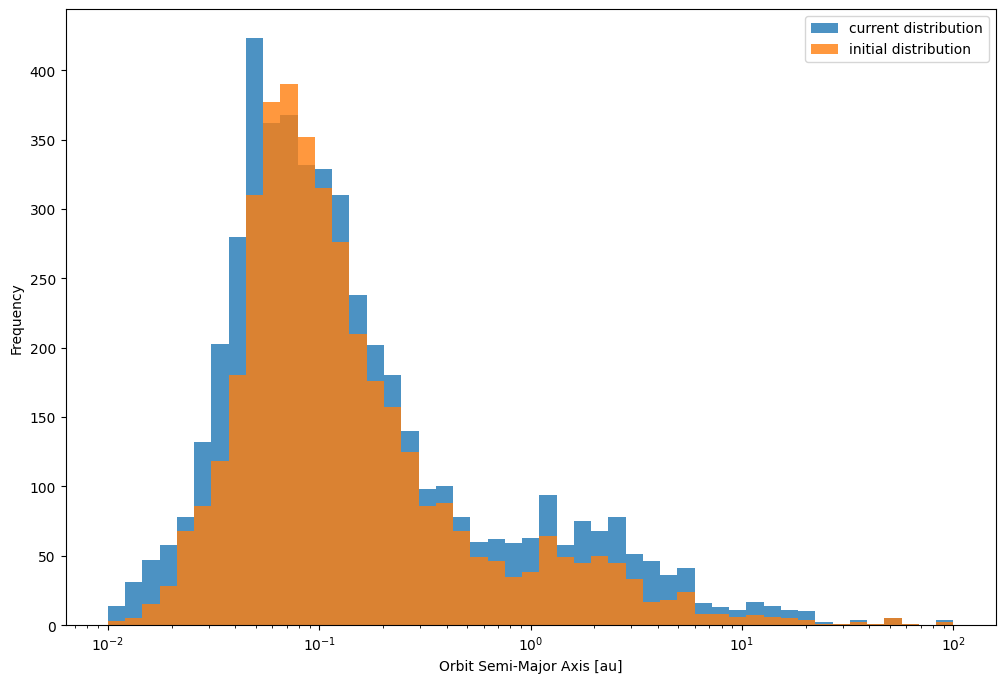

In [22]:
bins=np.logspace(np.log10(0.01),np.log10(100.0), 50)
ax = df['Orbit Semi-Major Axis [au]'].plot.hist(bins=bins, logx=True, alpha=0.8, histtype='bar', label="current distribution")
a0_au.plot.hist(ax=ax, bins=bins, logx=True, alpha=0.8, histtype='bar', label="initial distribution")
ax.set_xlabel("Orbit Semi-Major Axis [au]")
ax.legend()

Text(0.5, 0, 'Change in Orbit Semi-Major Axis [au]')

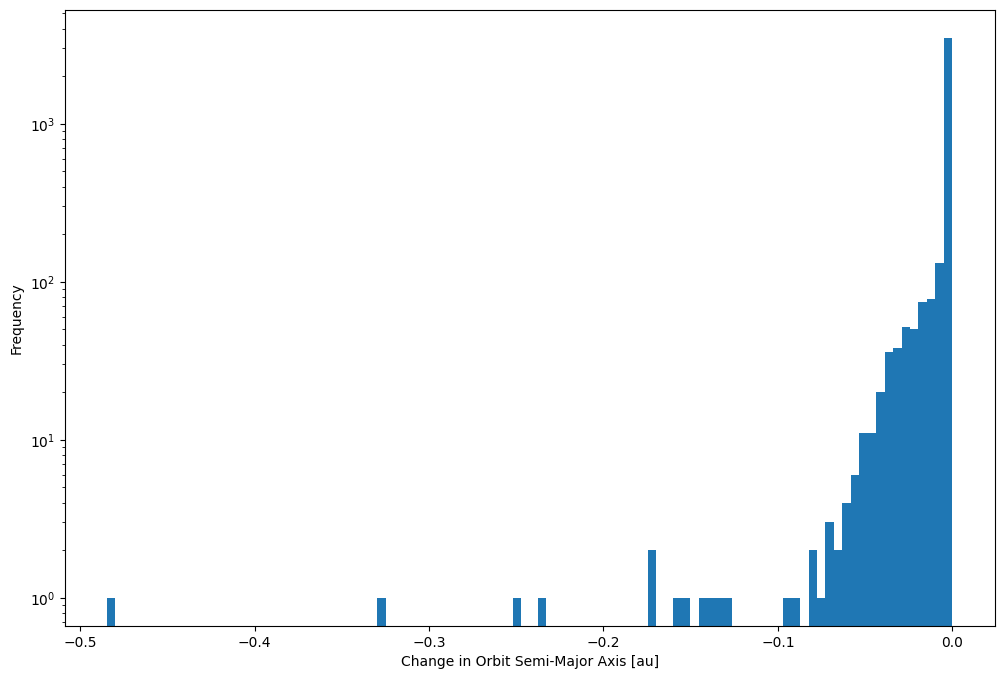

In [23]:
ax = (df['Orbit Semi-Major Axis [au]'] - a0_au).plot.hist(bins=100, log=True)
ax.set_xlabel("Change in Orbit Semi-Major Axis [au]")

Are eccentricities close to zero? Can they really be neglected? Plot the top 50 planets eccentricities and plot eccentricity vs da/dt

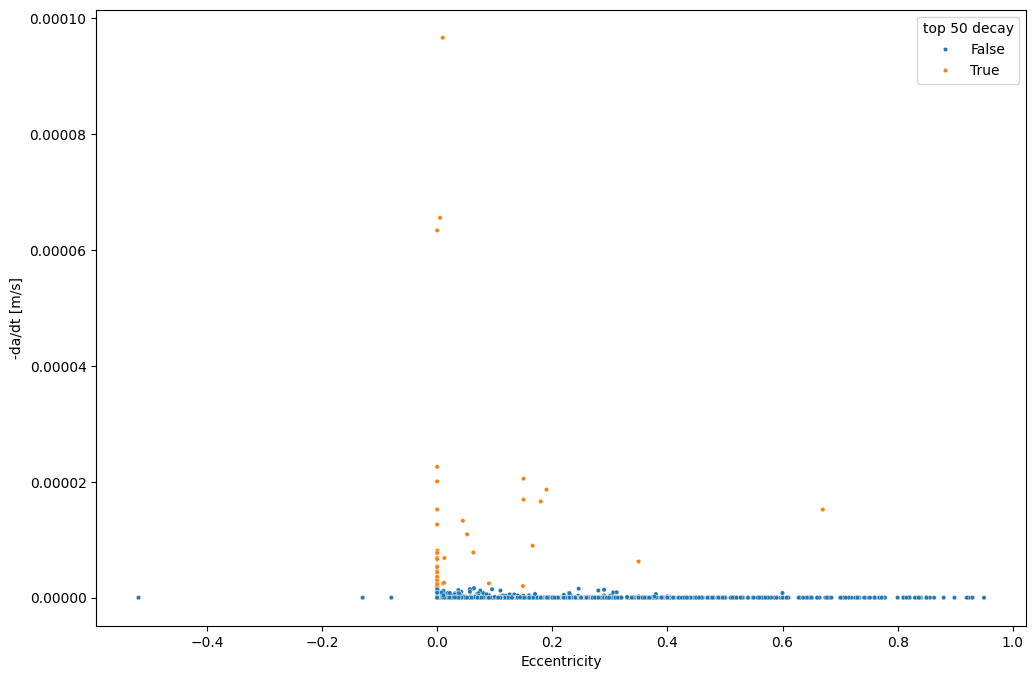

In [24]:
is_top_50 = pd.Series(df.index.isin(top_50_planets.index)).rename("top 50 decay")
ax = sns.scatterplot(data=df,
                x=df['Eccentricity'],
                y=neg_da_dt,
                s=10,
                hue=is_top_50,
               )
ax.set(xscale="linear", yscale="linear")
plt.show()

In [25]:
(df['Eccentricity'] < 0.0001).sum()

2881

The relationship of eccentricity vs decay for a typical hot Jupiter:

<Axes: xlabel='e', ylabel='-da/dt [m/s]'>

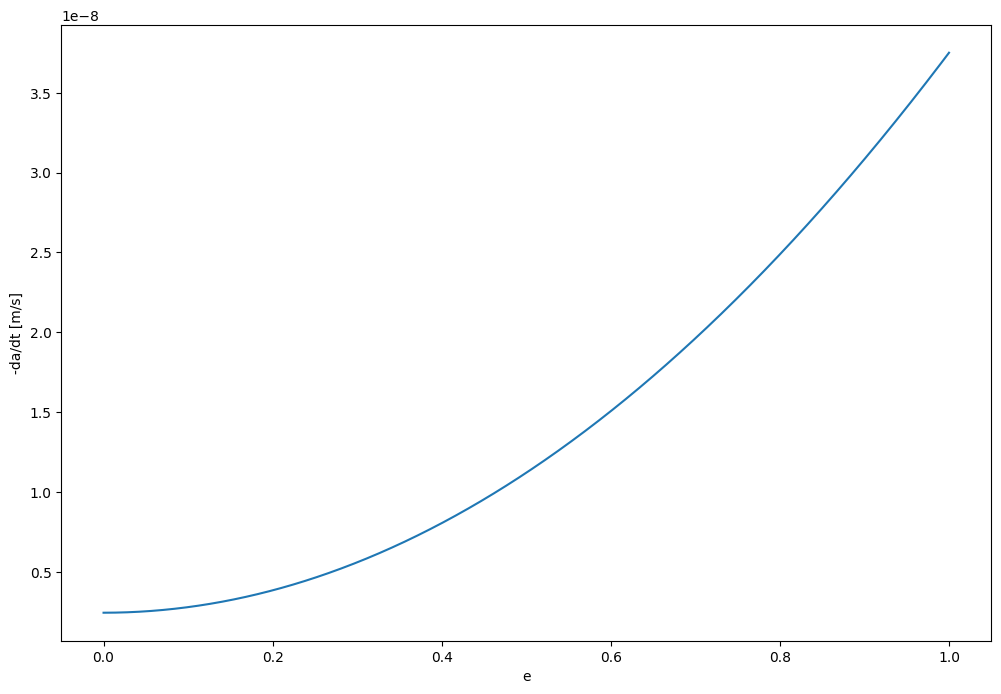

In [26]:
hj_Rp = 1 * earth_radius
hj_Mp = 10 * earth_mass
hj_Rs = 1.5 * solar_radius
hj_Ms = 1.5 * solar_mass
hj_a = 0.05 * sp.constants.au

Qs = 10 ** 5.5
Qp = 10 ** 6.5

e = np.linspace(0, 1, num=1000)
neg_da_dts_by_e = \
    (9/2 * ((sp.constants.G / hj_Ms) ** 0.5) * ((hj_Rs ** 5 * hj_Mp) / Qs) * (1 + (57/4 * e ** 2)) + \
    63/2 * ((sp.constants.G * hj_Ms ** 3) ** 0.5) * (hj_Rp ** 5 / (Qp * hj_Mp)) * e ** 2) * (hj_a ** -5.5)

pd.Series(neg_da_dts_by_e, index=e).plot(xlabel="e", ylabel="-da/dt [m/s]")

Potentially a factor of 10 or so difference for e ~ 0.4, but the difference to the basic analysis is small for all of the top 50 planets identified above.

#### Analysis (including eccentricities):

In [130]:
e = df['Eccentricity']
e_l = (df['Eccentricity'] + df['Eccentricity Lower Unc.']).fillna(e).fillna(0)
e_u = (df['Eccentricity'] + df['Eccentricity Upper Unc.']).fillna(e).fillna(0)

Qs = 10 ** 5.5
Qp = 10 ** 6.5

neg_da_dt_ecc = \
    (9/2 * ((sp.constants.G / Ms) ** 0.5) * ((Rs ** 5 * Mp) / Qs) * (1 + (57/4 * e ** 2)) + \
    63/2 * ((sp.constants.G * Ms ** 3) ** 0.5) * (Rp ** 5 / (Qp * Mp)) * e ** 2) * (a ** -5.5)
neg_da_dt_ecc_lower_bound = \
    (9/2 * ((sp.constants.G / Ms_u) ** 0.5) * ((Rs_l ** 5 * Mp_l) / Qs) * (1 + (57/4 * e_l ** 2)) + \
    63/2 * ((sp.constants.G * Ms_l ** 3) ** 0.5) * (Rp_l ** 5 / (Qp * Mp_u)) * e_l ** 2) * (a_l ** -5.5)
neg_da_dt_ecc_upper_bound = \
    (9/2 * ((sp.constants.G / Ms_l) ** 0.5) * ((Rs_u ** 5 * Mp_u) / Qs) * (1 + (57/4 * e_u ** 2)) + \
    63/2 * ((sp.constants.G * Ms_u ** 3) ** 0.5) * (Rp_u ** 5 / (Qp * Mp_l)) * e_u ** 2) * (a_u ** -5.5)
lower_bound_error_ecc = np.abs(neg_da_dt_ecc - neg_da_dt_ecc_lower_bound)
upper_bound_error_ecc = np.abs(neg_da_dt_ecc_upper_bound - neg_da_dt_ecc)
neg_da_dt_ecc = neg_da_dt_ecc.rename("-da/dt [m/s]")

In [103]:
stellar_tides = \
    (9/2 * ((sp.constants.G / Ms) ** 0.5) * ((Rs ** 5 * Mp) / Qs) * (1 + (57/4 * e ** 2))) * (a ** -5.5)

planetary_tides = \
    (63/2 * ((sp.constants.G * Ms ** 3) ** 0.5) * (Rp ** 5 / (Qp * Mp)) * e ** 2) * (a ** -5.5)

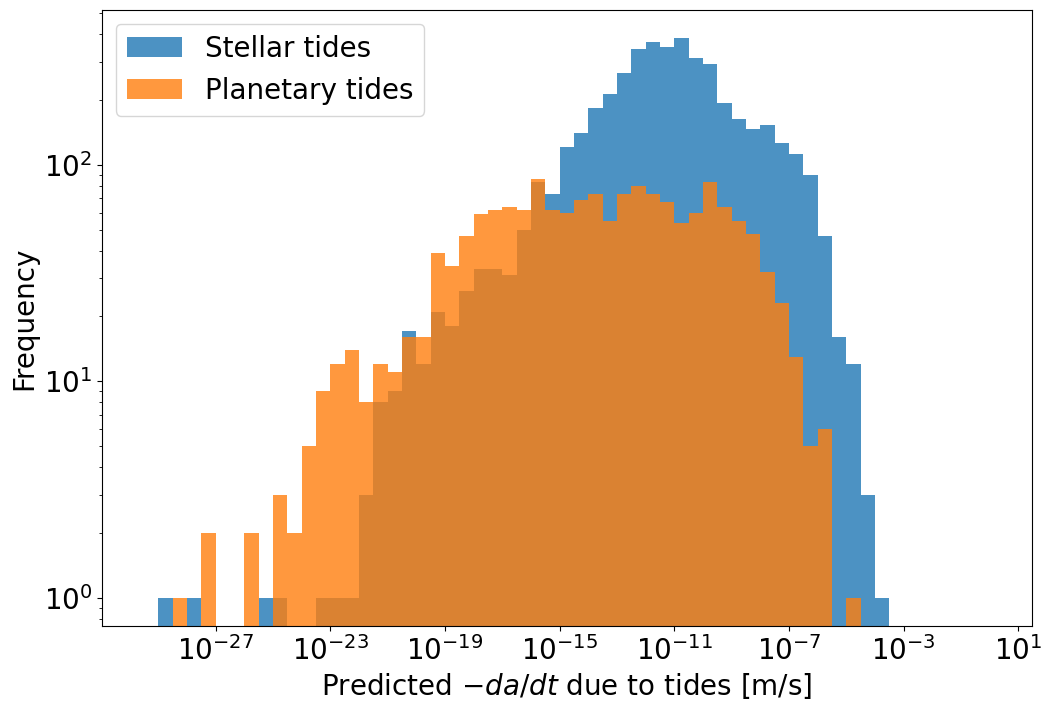

In [104]:
plt.rcParams.update({'font.size': 20})
bins = np.sort(np.power(10, -np.arange(0,30,0.5,dtype=float)))
ax = stellar_tides.plot.hist(bins=bins, log=True, label="Stellar tides", alpha=0.8)
planetary_tides.plot.hist(ax=ax, bins=bins, log=True, label="Planetary tides", alpha=0.8)
plt.xscale('log')
ax.set_xlabel("Predicted $-da/dt$ due to tides [m/s]")
ax.legend()

In [96]:
df.head()

rowid Planet Name Host Name Planet Letter      HD ID      HIP ID  \
0      1    11 Com b    11 Com             b  HD 107383   HIP 60202   
1      2    11 UMi b    11 UMi             b  HD 136726   HIP 74793   
2      3    14 And b    14 And             b  HD 221345  HIP 116076   
3      4    14 Her b    14 Her             b  HD 145675   HIP 79248   
4      5  16 Cyg B b  16 Cyg B             b  HD 186427   HIP 96901   

          TIC ID                       GAIA ID  Number of Stars  \
0   TIC 72437047  Gaia DR2 3946945413106333696                2   
1  TIC 230061010  Gaia DR2 1696798367260229376                1   
2  TIC 333225860  Gaia DR2 1920113512486282240                1   
3  TIC 219483057  Gaia DR2 1385293808145621504                1   
4   TIC 27533327  Gaia DR2 2135550755683407232                3   

   Number of Planets  Number of Moons  Circumbinary Flag Discovery Method  \
0                  1                0                  0  Radial Velocity   
1                  1                0                  0  Radial Velocity   
2                  1                0                  0  Radial Velocity   
3                  2                0                  0  Radial Velocity   
4                  1                0                  0  Radial Velocity   

   Discovery Year                                Discovery Reference  \
0            2007  <a refstr=LIU_ET_AL__2008 href=https://ui.adsa...   
1            2009  <a refstr=DOLLINGER_ET_AL__2009 href=https://u...   
2            2008  <a refstr=SATO_ET_AL__2008 href=https://ui.ads...   
3            2002  <a refstr=BUTLER_ET_AL__2003 href=https://ui.a...   
4            1996  <a refstr=COCHRAN_ET_AL__1997 href=https://ui....   

  Discovery Publication Date Discovery Locale  \
0                    2008-01           Ground   
1                    2009-10           Ground   
2                    2008-12           Ground   
3                    2003-01           Ground   
4                    1997-07           Ground   

                       Discovery Facility            Discovery Telescope  \
0                        Xinglong Station               2.16 m Telescope   
1  Thueringer Landessternwarte Tautenburg  2.0 m Alfred Jensch Telescope   
2       Okayama Astrophysical Observatory               1.88 m Telescope   
3                  W. M. Keck Observatory          10 m Keck I Telescope   
4                  Multiple Observatories            Multiple Telescopes   

         Discovery Instrument  Detected by Radial Velocity Variations  \
0  Coude Echelle Spectrograph                                       1   
1  Coude Echelle Spectrograph                                       1   
2  HIDES Echelle Spectrograph                                       1   
3          HIRES Spectrometer                                       1   
4        Multiple Instruments                                       1   

   Detected by Pulsar Timing Variations  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   

   Detected by Pulsation Timing Variations  Detected by Transits  \
0                                        0                     0   
1                                        0                     0   
2                                        0                     0   
3                                        0                     0   
4                                        0                     0   

   Detected by Astrometric Variations  \
0                                   0   
1                                   0   
2                                   0   
3                                   0   
4                                   0   

   Detected by Orbital Brightness Modulations  Detected by Microlensing  \
0                                           0                         0   
1                    

In [114]:
stellar_tides_dp_de = 3 * sp.constants.pi * np.sqrt((df["Orbit Semi-Major Axis [au]"] * sp.constants.au)  / (sp.constants.G * df["Stellar Mass [Solar mass]"] * solar_mass)) * stellar_tides
stellar_tides_dp_de = stellar_tides_dp_de * 60 * 60 * 24 * 365 * 1000

In [116]:
planetary_tides_dp_de = 3 * sp.constants.pi * np.sqrt((df["Orbit Semi-Major Axis [au]"] * sp.constants.au)  / (sp.constants.G * df["Stellar Mass [Solar mass]"] * solar_mass)) * planetary_tides
planetary_tides_dp_de = planetary_tides_dp_de * 60 * 60 * 24 * 365 * 1000

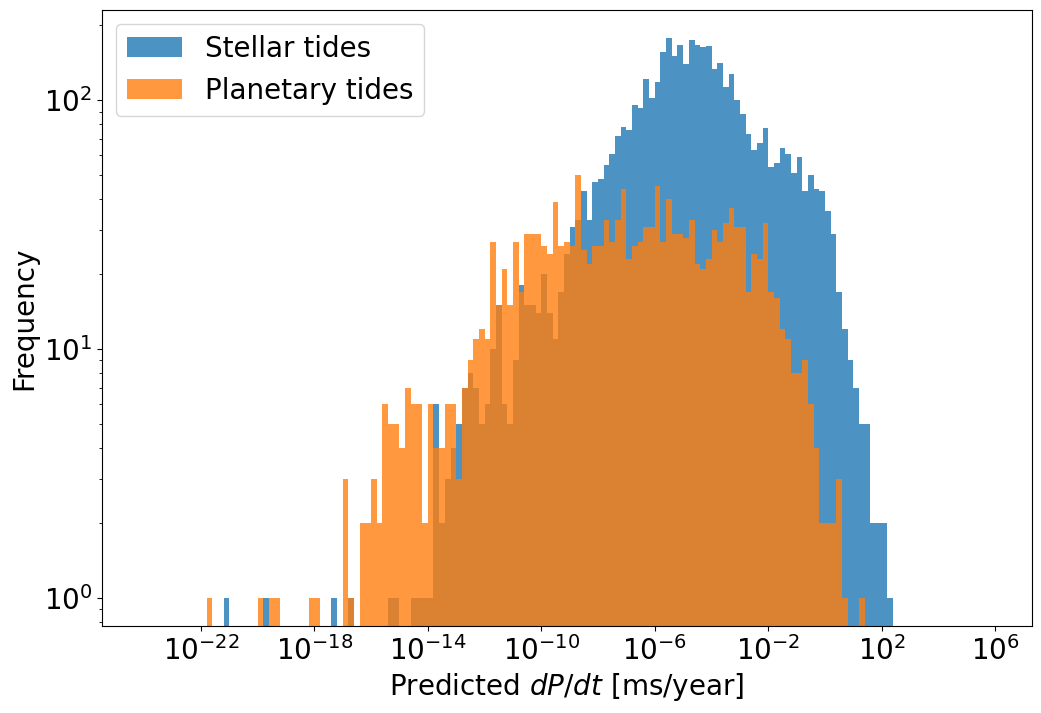

In [128]:
plt.rcParams.update({'font.size': 20})
bins = np.sort(np.power(10, np.arange(-24,6,0.2,dtype=float)))
ax = stellar_tides_dp_de.plot.hist(bins=bins, log=True, label="Stellar tides", alpha=0.8)
planetary_tides_dp_de.plot.hist(ax=ax, bins=bins, log=True, label="Planetary tides", alpha=0.8)
plt.xscale('log')
ax.set_xlabel("Predicted $dP/dt$ [ms/year]")
ax.legend()

Text(0.5, 0, 'Predicted -da/dt [m/s]')

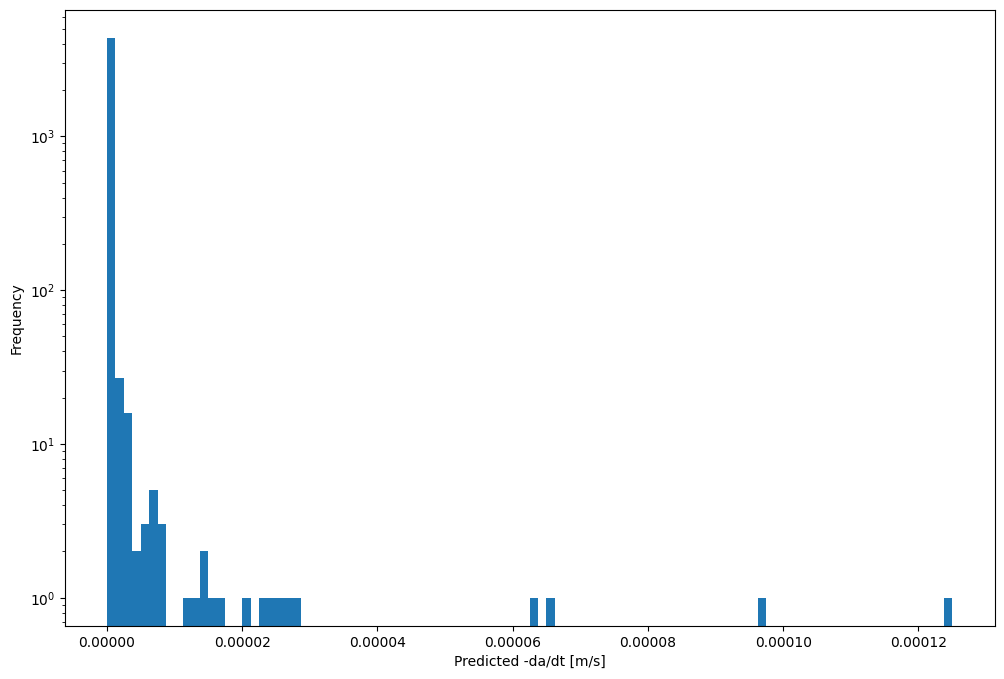

In [30]:
ax = neg_da_dt_ecc.plot.hist(bins=100, log=True)
ax.set_xlabel("Predicted -da/dt [m/s]")

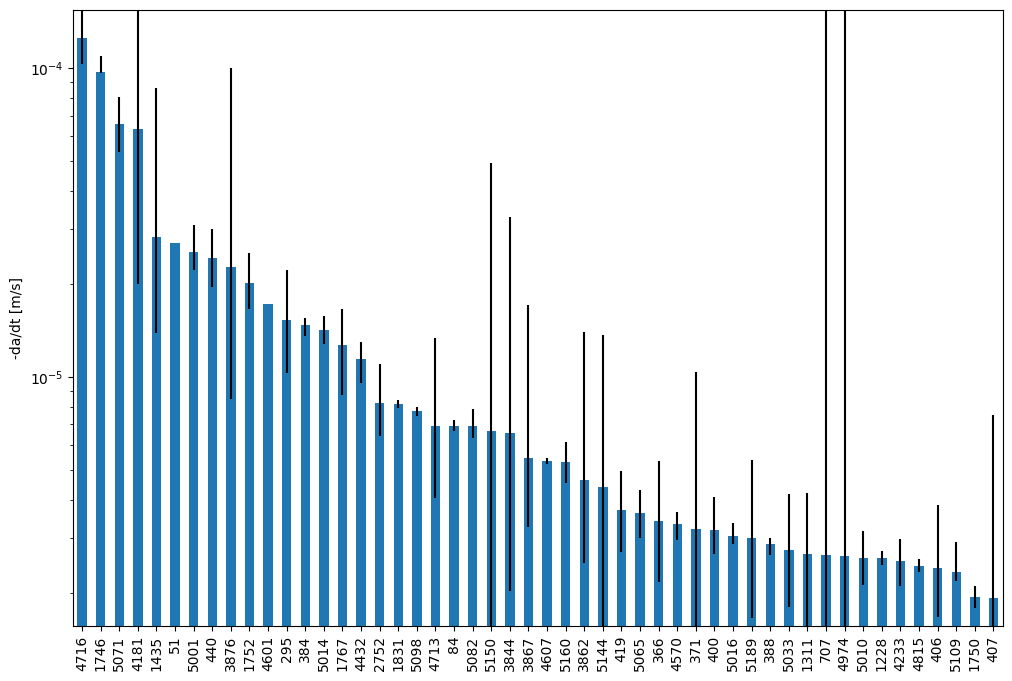

In [31]:
top_50_planets_ecc = neg_da_dt_ecc.sort_values(ascending=False).head(50)
top_50_ecc_errs = np.array(list(zip(lower_bound_error_ecc.loc[top_50_planets_ecc.index], upper_bound_error_ecc.loc[top_50_planets_ecc.index]))).transpose()
top_50_planets_ecc.plot.bar(ylabel=top_50_planets.name, yerr=top_50_ecc_errs, log=True)
plt.show()

In [32]:
len(set(top_50_planets_ecc.index) & set(top_50_planets.index))

42

Orbital decay rates are of the same magnitude and 42 planets are shared among the top 50. The classical equations are sensitive to eccentricity but the closeness of known planets dominates the effect.

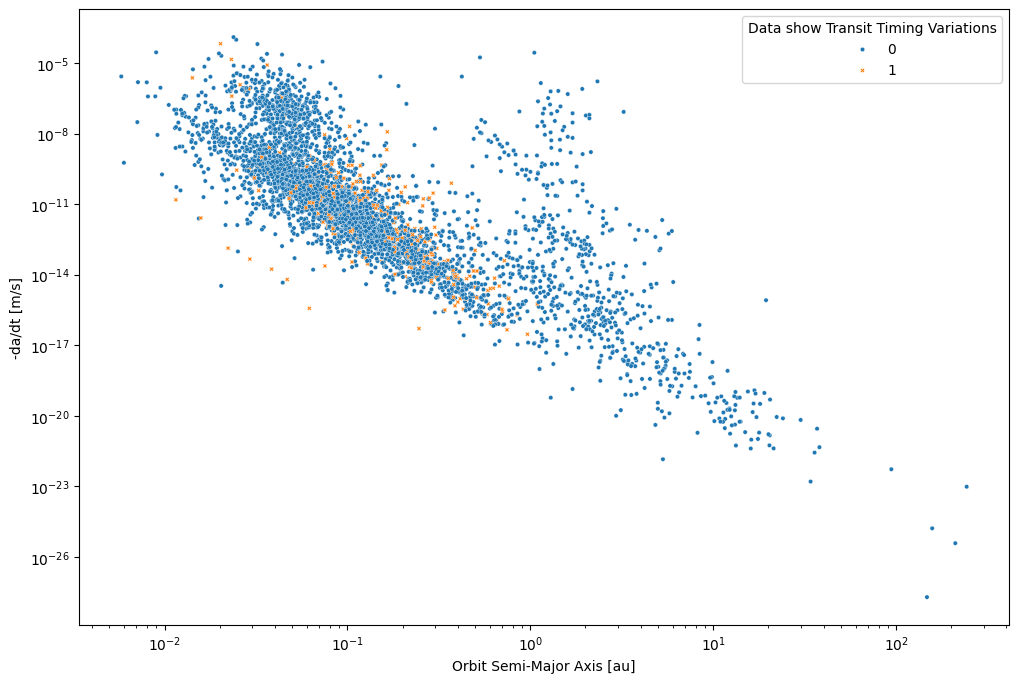

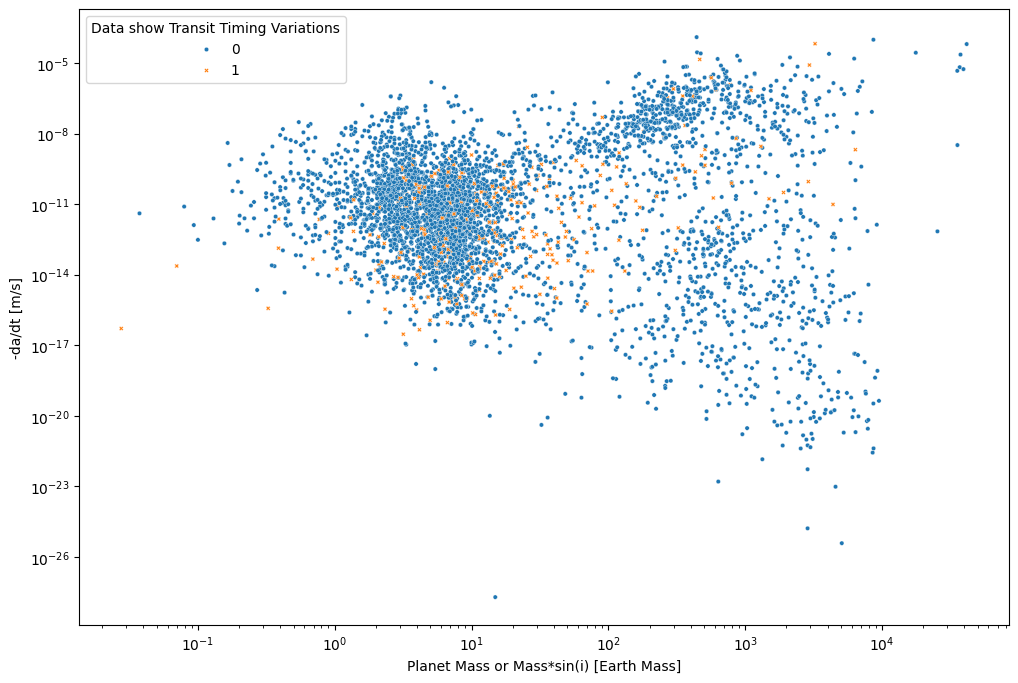

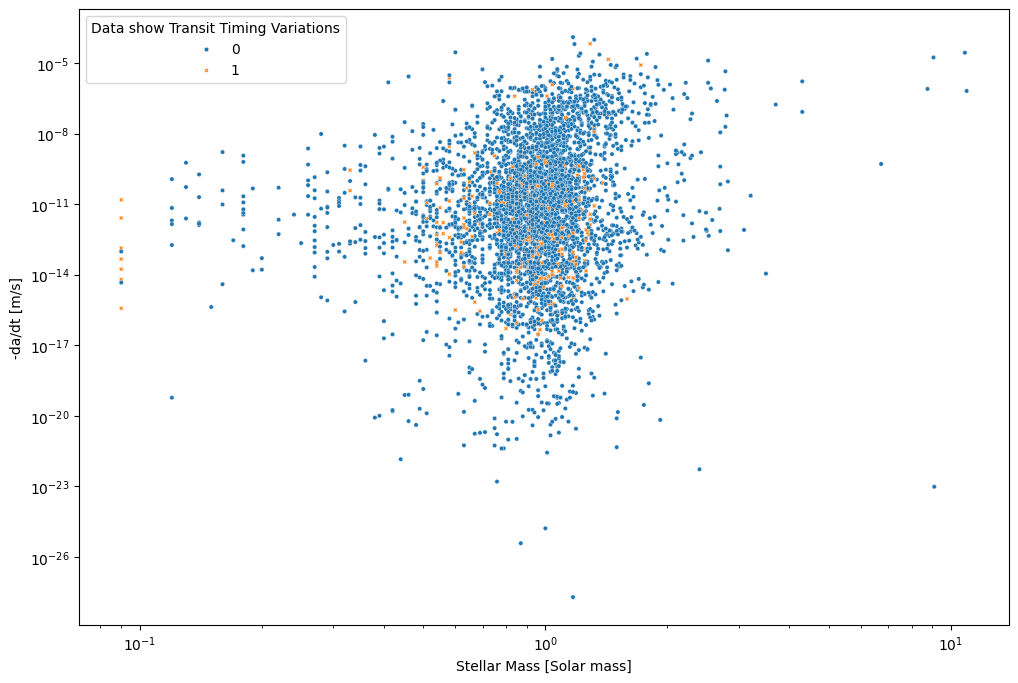

In [33]:
ax = sns.scatterplot(data=df,
                x=df['Orbit Semi-Major Axis [au]'],
                y=neg_da_dt_ecc,
                hue='Data show Transit Timing Variations',
                style='Data show Transit Timing Variations',
                s=10,
               )
ax.set(xscale="log", yscale="log")
plt.show()

ax = sns.scatterplot(data=df,
                x=df['Planet Mass or Mass*sin(i) [Earth Mass]'],
                y=neg_da_dt_ecc,
                hue='Data show Transit Timing Variations',
                style='Data show Transit Timing Variations',
                s=10,
               )
ax.set(xscale="log", yscale="log")
plt.show() 

ax = sns.scatterplot(data=df,
                x=df['Stellar Mass [Solar mass]'],
                y=neg_da_dt_ecc,
                hue='Data show Transit Timing Variations',
                style='Data show Transit Timing Variations',
                s=10,
               )
ax.set(xscale="log", yscale="log")
plt.show() 

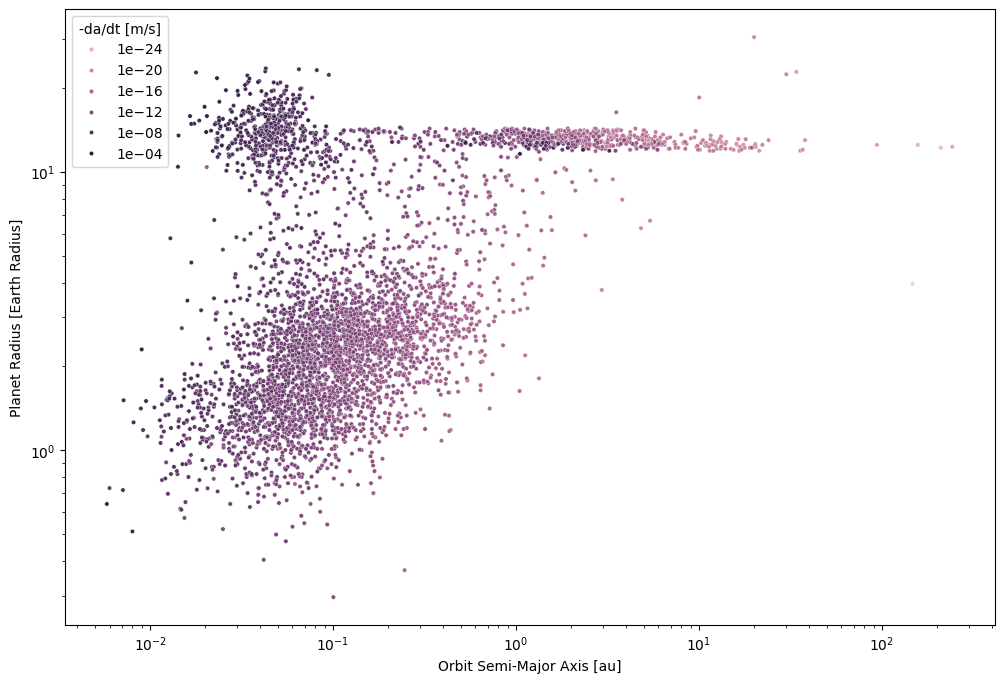

In [34]:
ax = sns.scatterplot(data=df,
                x=df['Orbit Semi-Major Axis [au]'],
                y=df['Planet Radius [Earth Radius]'],
                s=10,
                hue=neg_da_dt_ecc,
                hue_norm=colors.LogNorm(),
               )
ax.set(xscale="log", yscale="log")
plt.show()

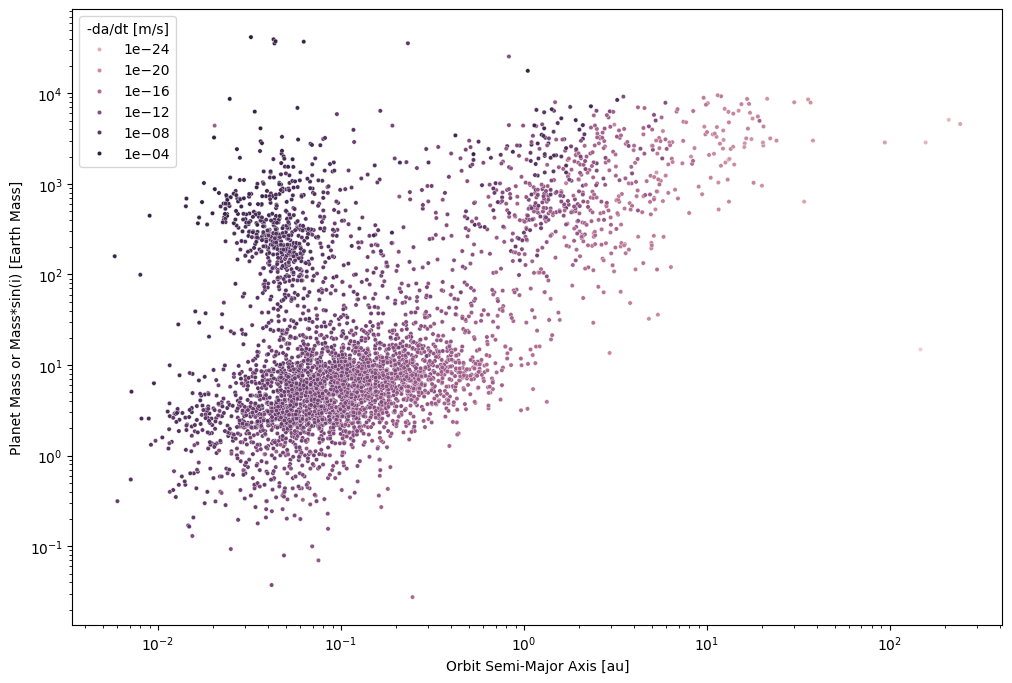

In [35]:
ax = sns.scatterplot(data=df,
                x=df['Orbit Semi-Major Axis [au]'],
                y=df['Planet Mass or Mass*sin(i) [Earth Mass]'],
                s=10,
                hue=neg_da_dt_ecc,
                hue_norm=colors.LogNorm(),
               )
ax.set(xscale="log", yscale="log")
plt.show()

As before, the hot Jupiters (large planets close to their star) are predicted to have the largest orbital decay.

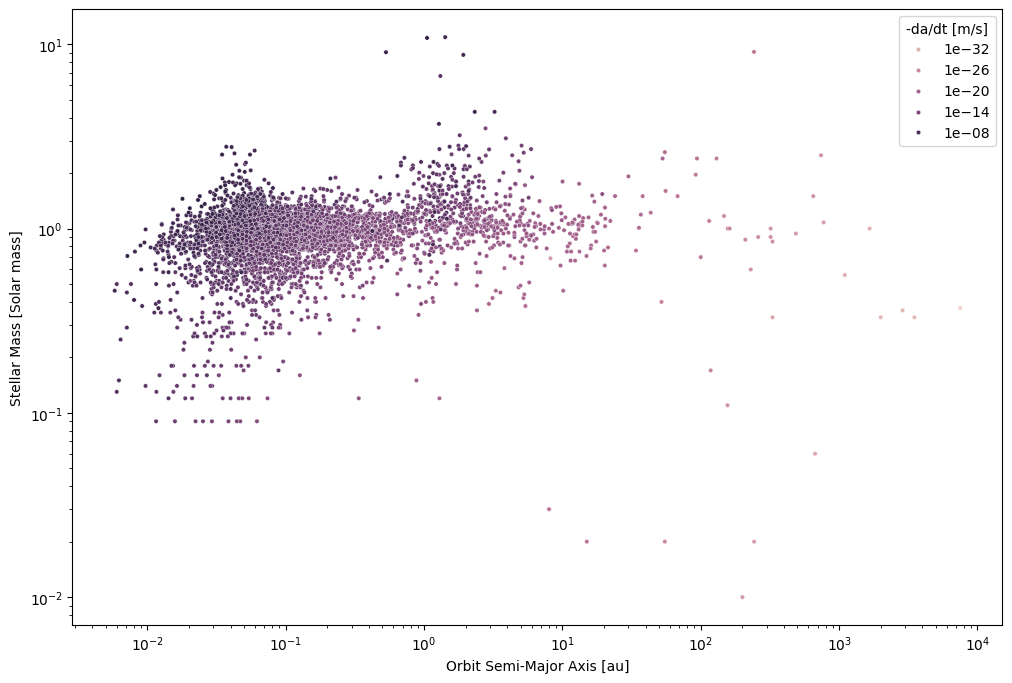

In [36]:
ax = sns.scatterplot(data=df,
                x=df['Orbit Semi-Major Axis [au]'],
                y=df['Stellar Mass [Solar mass]'],
                s=10,
                hue=neg_da_dt,
                hue_norm=colors.LogNorm(),
               )
ax.set(xscale="log", yscale="log")
plt.show()

Compute the period decay per year and per epoch where:

$\frac{dP}{dE}=\frac{dt}{dE}\frac{dP}{dt}=P\frac{dP}{dt}$

In [131]:
df["-dP/dt"] = 3 * sp.constants.pi * np.sqrt((df["Orbit Semi-Major Axis [au]"] * sp.constants.au)  / (sp.constants.G * df["Stellar Mass [Solar mass]"] * solar_mass)) * neg_da_dt_ecc
df["-dP/dt [ms/year]"] = df["-dP/dt"] * 60 * 60 * 24 * 365 * 1000

In [132]:
df.loc[5014]["-dP/dt [ms/year]"] # WASP 12b decay in ms/year

17.959838667121904

In [133]:
df["-dP/dE [ms/epoch]"] = df["-dP/dt"] * df["Orbital Period [days]"] * 24 * 60 * 60 * 1000

In [134]:
dp_de = df.loc[5014]["-dP/dE [ms/epoch]"] # WASP 12b decay in ms/epoch
dp_de

0.053703361967315594

In [135]:
orbits_per_10_years = 10 * 365 / df.loc[5014]['Orbital Period [days]']
orbits_per_10_years

3344.267101574096

In [136]:
(0.5 * dp_de * orbits_per_10_years**2) / 1000  # 300s expected TTV after 10 years

300.31248802017075

In [137]:
fields = ['Planet Name', 'Orbital Period [days]', 'Orbit Semi-Major Axis [au]', 'Planet Radius [Earth Radius]', 'Planet Mass or Mass*sin(i) [Earth Mass]', 'Stellar Mass [Solar mass]', 'Stellar Radius [Solar Radius]', 'Data show Transit Timing Variations', 'Eccentricity', '-dP/dt [ms/year]', '-dP/dE [ms/epoch]']
df.loc[df.sort_values(by="-dP/dt [ms/year]", ascending=False).head(20).index][fields]

Planet Name  Orbital Period [days]  Orbit Semi-Major Axis [au]  \
4716         OGLE-TR-56 b               1.211919                     0.02383   
1746             KELT-1 b               1.217514                     0.02466   
4181         Kepler-718 b               2.052350                     0.03220   
51           BD+20 2457 b             379.630000                     1.05000   
5071            WASP-18 b               0.941452                     0.02024   
4601  NGC 2682 Sand 364 b             121.710000                     0.53000   
3876         Kepler-493 b               3.003877                     0.04390   
440             HATS-70 b               1.888238                     0.03632   
1435              K2-22 b               0.381073                     0.00900   
5001           WASP-103 b               0.925542                     0.01985   
4432          Kepler-91 b               6.246580                     0.07310   
1752            KELT-16 b               0.968995                     0.02044   
295               GPX-1 b               1.744579                     0.03380   
384             HATS-18 b               0.837840                     0.01740   
5014            WASP-12 b               1.091420                     0.02320   
4974   TYC 4282-00605-1 b             101.540000                     0.42200   
2752        Kepler-1658 b               3.849373                     0.05440   
1767             KELT-9 b               1.481124                     0.03462   
1035            HD 4760 b             434.000000                     1.14000   
3844         Kepler-471 b               5.014235                     0.06260   

      Planet Radius [Earth Radius]  Planet Mass or Mass*sin(i) [Earth Mass]  \
4716                        15.278                                441.77000   
1746                        12.442                               8654.15000   
4181                        16.560                              41600.00000   
51                          11.600                              17668.16970   
5071                        13.899                               3241.84975   
4601                        12.700                               2126.28270   
3876                        15.130                              37500.00000   
440                         15.513                               4100.00700   
1435                         2.300                                444.96200   
5001                        17.127                                473.54700   
4432                        15.323                                257.44230   
1752                        15.861                                874.03250   
295                         16.477                               6261.21962   
384                         14.897                                629.14449   
5014                        21.712                                465.62095   
4974                        12.400                               3426.20740   
2752                        11.994                               1868.84040   
1767                        21.196                                915.35040   
1035                        12.300                               4417.83700   
3844                        14.960                              37000.00000   

      Stellar Mass [Solar mass]  Stellar Radius [Solar Radius]  \
4716                       1.17                           1.74   
1746                       1.32                           1.46   
4181                       1.18                           1.30   
51                        10.83                          71.02   
5071                       1.29                           1.32   
4601                       9.06                          39.59   
3876                       1.36                           1.54   
440                        1.78                           1.88   
1435                       0.60                           0.58   
5001         

In [145]:
(df["-dP/dt [ms/year]"] > 10).sum()

25

In [146]:
df[df["-dP/dt [ms/year]"] > 10]

rowid          Planet Name          Host Name Planet Letter      HD ID  \
51       52         BD+20 2457 b         BD+20 2457             b        NaN   
84       85           CoRoT-14 b           CoRoT-14             b        NaN   
295     296              GPX-1 b              GPX-1             b        NaN   
384     385            HATS-18 b            HATS-18             b        NaN   
440     441            HATS-70 b            HATS-70             b        NaN   
1035   1036            HD 4760 b            HD 4760             b    HD 4760   
1125   1126           HD 81817 c           HD 81817             c   HD 81817   
1435   1436              K2-22 b              K2-22             b        NaN   
1746   1747             KELT-1 b             KELT-1             b        NaN   
1752   1753            KELT-16 b            KELT-16             b        NaN   
1767   1768             KELT-9 b             KELT-9             b  HD 195689   
1831   1832             KOI-13 b             KOI-13             b        NaN   
2752   2753        Kepler-1658 b        Kepler-1658             b        NaN   
3844   3845         Kepler-471 b         Kepler-471             b        NaN   
3867   3868         Kepler-488 b         Kepler-488             b        NaN   
3876   3877         Kepler-493 b         Kepler-493             b        NaN   
4181   4182         Kepler-718 b         Kepler-718             b        NaN   
4432   4433          Kepler-91 b          Kepler-91             b        NaN   
4601   4602  NGC 2682 Sand 364 b  NGC 2682 Sand 364             b        NaN   
4713   4714        OGLE-TR-132 b        OGLE-TR-132             b        NaN   
4716   4717         OGLE-TR-56 b         OGLE-TR-56             b        NaN   
4974   4975   TYC 4282-00605-1 b   TYC 4282-00605-1             b        NaN   
5001   5002           WASP-103 b           WASP-103             b        NaN   
5014   5015            WASP-12 b            WASP-12             b        NaN   
5071   5072            WASP-18 b            WASP-18             b   HD 10069   

          HIP ID          TIC ID                       GAIA ID  \
51           NaN    TIC 95359428   Gaia DR2 625137162857354880   
84           NaN   TIC 282706928  Gaia DR2 3101145195794755072   
295          NaN   TIC 245392284   Gaia DR2 457317534880081152   
384          NaN    TIC 14614418  Gaia DR2 3483636295772522880   
440          NaN    TIC 98545929  Gaia DR2 5605119586158973440   
1035    HIP 3869   TIC 405337087  Gaia DR2 2556428551067486720   
1125   HIP 47193   TIC 137603530  Gaia DR2 1144716265940854016   
1435         NaN   TIC 363445338  Gaia DR2 3811002791880297600   
1746         NaN   TIC 432549364  Gaia DR2 2881784280929695360   
1752         NaN   TIC 236445129  Gaia DR2 1864885215233116032   
1767  HIP 101252    TIC 16740101  Gaia DR2 2064327278651198336   
1831         NaN   TIC 158324245  Gaia DR2 2130632159134827392   
2752         NaN   TIC 377873569  Gaia DR2 2052194374009877376   
3844         NaN   TIC 268604331  Gaia DR2 2075972481191725696   
3867         NaN    TIC 48217457  Gaia DR2 2131712669826755328   
3876         NaN   TIC 139104940  Gaia DR2 2076166029596100224   
4181         NaN   TIC 268924036  Gaia DR2 2075964612812129792   
4432         NaN   TIC 352011875  Gaia DR2 2105909326647414400   
4601         NaN   TIC 437030651   Gaia DR2 598955115235894784   
4713         NaN   TIC 465144510  Gaia DR2 5241964708164136192   
4716         NaN  TIC 1425441246  Gaia DR2 4056326681029056896   
4974         NaN    TIC 13105061  Gaia DR2 2207199228316679808   
5001         NaN   TIC 276754403  Gaia DR2 4439085988769170432   
5014         NaN    TIC 86396382  Gaia DR2 3435282862461427072   
5071    HIP 7562   TIC 100100827  Gaia DR2 4955371367334610048   

      Number of Stars  Number of Planets  Number of Moons  Circumbinary Flag  \
51                  1                  2                0                  0   
84                  1                  1        

Other good candidate planets for investigation of orbital decay suggested by Turner all appear in this top 50.

To integrate and find initial distributions of eccentricity and orbital radius we need to numerically solve the coupled differential equation, since e is NOT constant.

#### Sanity check: how much shorter will the transit of WASP-12 b be over 10 years?

WASP 12-b is the only hot Jupiter confirmed to exhibit orbital decay as of 2020. The fact that the classical equations put it in our top 50 is reassuring.

In [44]:
wasp_12b = df.loc[5014]

In [45]:
decay_rate = neg_da_dt_ecc.loc[5014]
decay_rate_in_m_per_year = decay_rate * 60 * 60 * 24 * 365
decay_rate_in_m_per_year

445.6694628144227

What will the change in period be per year?

In [46]:
a_wasp12b = wasp_12b["Orbit Semi-Major Axis [au]"] * sp.constants.au
Ms_wasp12b = wasp_12b["Stellar Mass [Solar mass]"] * solar_mass
T = np.sqrt(4 * (sp.constants.pi ** 2) * (a_wasp12b ** 3) / (sp.constants.G * Ms_wasp12b))
T

93242.02388828681

In [47]:
dT_dt = 3 * sp.constants.pi * np.sqrt(a_wasp12b / (sp.constants.G * Ms_wasp12b)) * decay_rate
dT_dt * 60 * 60 * 24 * 365 * 1000 # ms per year

17.9598386671219

Agrees well with Turner (who used a Qs sqrt(10) smaller than mine, so their answer is roughly sqrt(10) larger. Let's try a range of Qs and Qp:

<Axes: xlabel='Qs', ylabel='-da/dt [m/s]'>

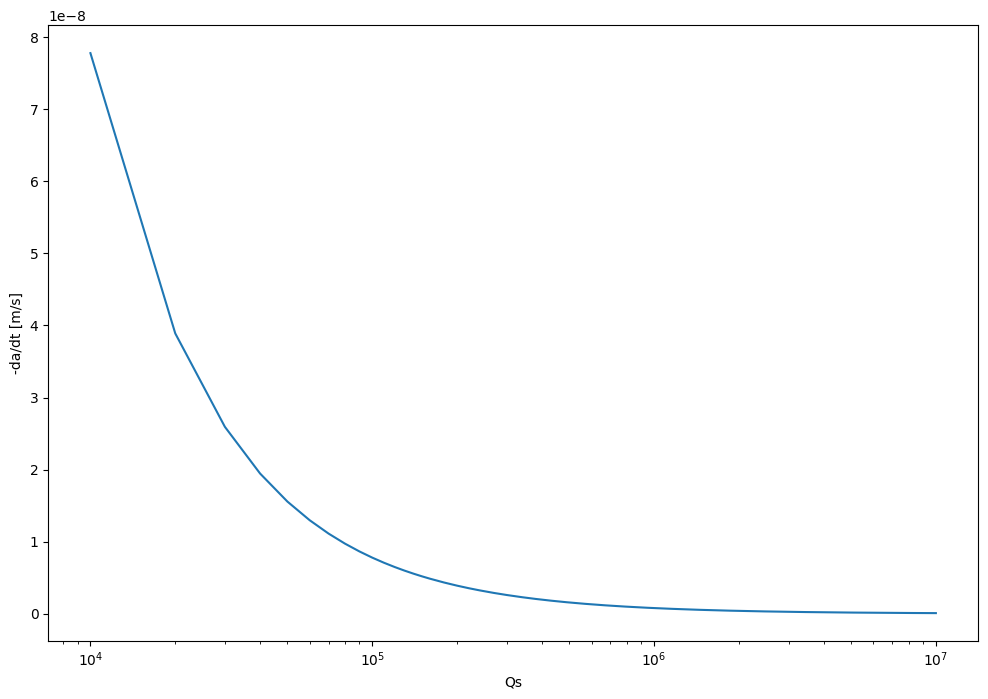

In [48]:
hj_Rp = 1 * earth_radius
hj_Mp = 10 * earth_mass
hj_Rs = 1.5 * solar_radius
hj_Ms = 1.5 * solar_mass
hj_a = 0.05 * sp.constants.au
e = 0.01
Qp = 10 ** 6.5

Qs = np.linspace(10 ** 4, 10 ** 7, num=1000)
neg_da_dts_by_e = \
    (9/2 * ((sp.constants.G / hj_Ms) ** 0.5) * ((hj_Rs ** 5 * hj_Mp) / Qs) * (1 + (57/4 * e ** 2)) + \
    63/2 * ((sp.constants.G * hj_Ms ** 3) ** 0.5) * (hj_Rp ** 5 / (Qp * hj_Mp)) * e ** 2) * (hj_a ** -5.5)

pd.Series(neg_da_dts_by_e, index=Qs).plot(xlabel="Qs", ylabel="-da/dt [m/s]", logx=True, logy=False)

<Axes: xlabel='Qp', ylabel='-da/dt [m/s]'>

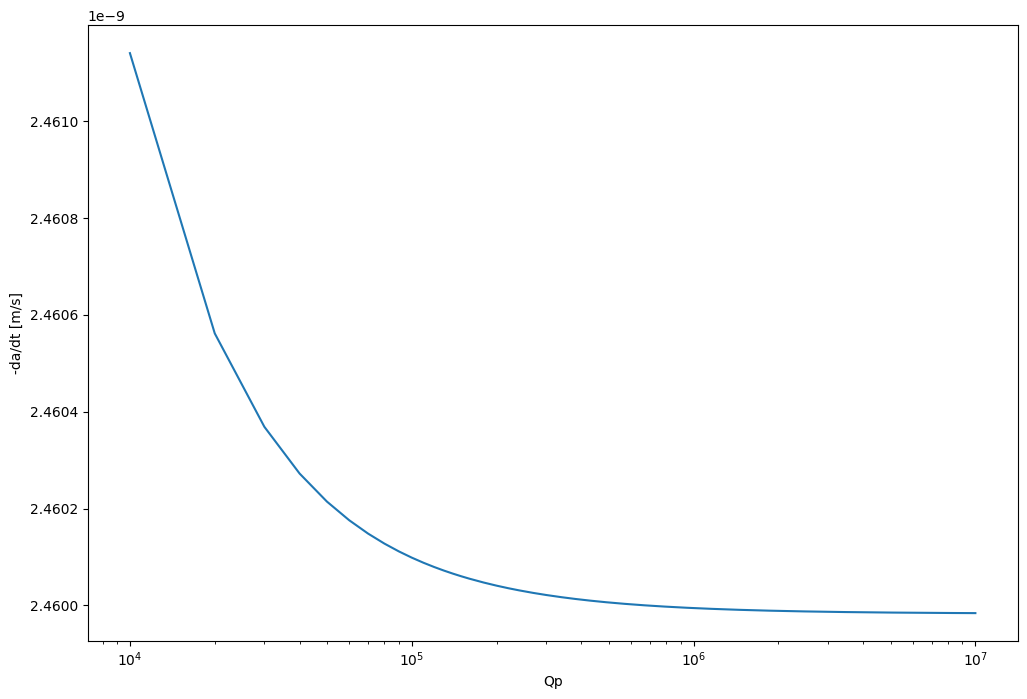

In [49]:
hj_Rp = 1 * earth_radius
hj_Mp = 10 * earth_mass
hj_Rs = 1.5 * solar_radius
hj_Ms = 1.5 * solar_mass
hj_a = 0.05 * sp.constants.au
e = 0.01
Qs = 10 ** 5.5

Qp = np.linspace(10 ** 4, 10 ** 7, num=1000)
neg_da_dts_by_e = \
    (9/2 * ((sp.constants.G / hj_Ms) ** 0.5) * ((hj_Rs ** 5 * hj_Mp) / Qs) * (1 + (57/4 * e ** 2)) + \
    63/2 * ((sp.constants.G * hj_Ms ** 3) ** 0.5) * (hj_Rp ** 5 / (Qp * hj_Mp)) * e ** 2) * (hj_a ** -5.5)

pd.Series(neg_da_dts_by_e, index=Qp).plot(xlabel="Qp", ylabel="-da/dt [m/s]", logx=True, logy=False)

The exact value of Qs has a big effect on the rate of decay according to this model, but less so the value of Qp.

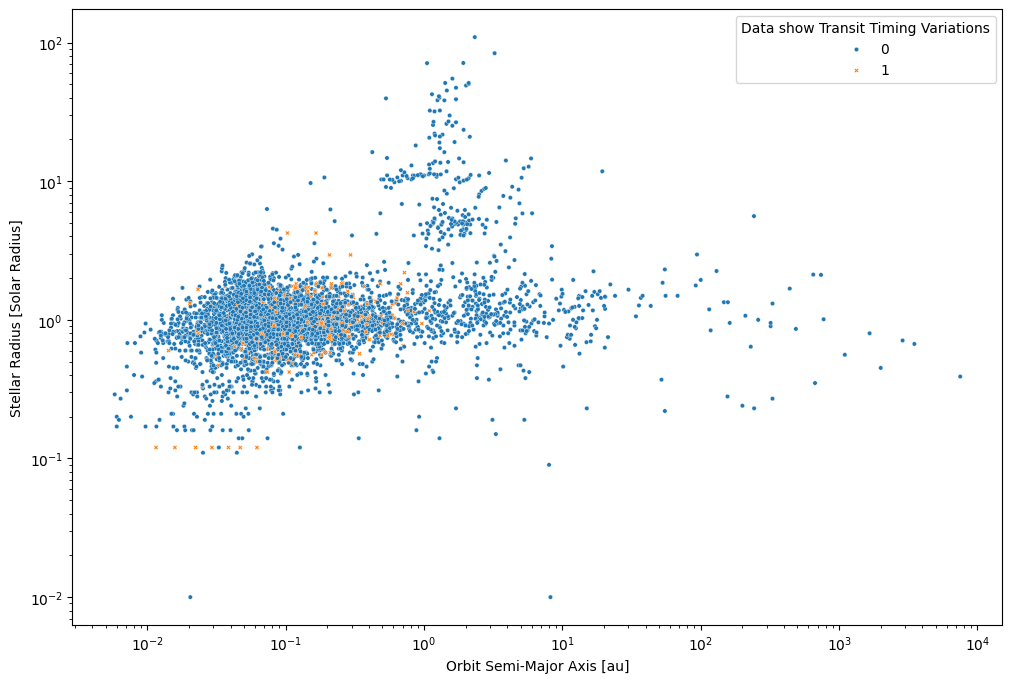

In [56]:
ax = sns.scatterplot(data=df,
                x=df['Orbit Semi-Major Axis [au]'],
                y=df['Stellar Radius [Solar Radius]'],
                hue='Data show Transit Timing Variations',
                style='Data show Transit Timing Variations',
                s=10,
               )
ax.set(xscale="log", yscale="log")
plt.show()


In [50]:
# how much shorter will the period be per epoch?
# does this line up with the WASP 12 b paper?

In [51]:
# try to replicate the results of the WASP 12 b paper i.e. deep dive into this planet
# try a deep dive into another planet in the top 50 list in a similar way

In [52]:
# can we use a non-constant Q* varying according to stellar parameters that we have available in the data?

In [53]:
# can we fit Qs and then infer stuff given physical models of Q? Could we then better predict the 